In [1]:
from SimPEG import *
from discretize import TensorMesh
from simpegEM1D import *
from scipy.constants import mu_0
import numpy as np
%pylab inline

sig_half = 1e-1
sig_blk = 1e0

frequency = np.array([382, 1822, 7970, 35920, 130100], dtype=float)
hz = get_vertical_discretization_frequency(frequency, sigma_background=sig_half)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC

FDsurvey = EM1DSurveyFD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    field_type = 'secondary',
    rx_type = 'ppm',
    src_type = 'VMD',
    offset = np.ones(frequency.size)*7.86,
    topo = np.r_[0., 0., 100.],
    depth = depth,
    frequency = frequency
)

chi_half = 0.
wires = maps.Wires(('sigma', mesh1D.nC),('h', 1))
expmap = maps.ExpMap(mesh1D)
# expmap_h = Maps.ExpMap(nP=1)
sigmaMap = expmap * wires.sigma
# hMap = expmap_h*wires.h
sig  = np.ones(FDsurvey.n_layer)*sig_half
blk_ind = (-20>LocSigZ) & (-40<LocSigZ)
sig[blk_ind] = sig_blk
m_true = np.r_[np.log(sig), FDsurvey.h]
m_true_dh = np.r_[np.log(sig), FDsurvey.h + 5.]
# dh = 0.01
# m_dx_p = np.r_[np.log(sig), FDsurvey.h+dh/2]
# m_dx_n = np.r_[np.log(sig), FDsurvey.h-dh/2]

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pi']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


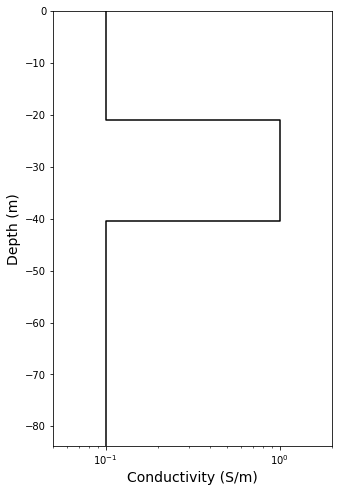

In [2]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D, showlayers=False)

In [3]:
sim = EM1DFMSimulation(
    mesh1D, survey=FDsurvey, sigmaMap=sigmaMap, hMap=wires.h,
    chi= np.zeros(FDsurvey.n_layer)
)
  
d_true = sim.dpred(m_true)
# d_p = FDsurvey.dpred(m_dx_p)
# d_n = FDsurvey.dpred(m_dx_n)
d_dh = sim.dpred(m_true_dh)
# J_h_diff = (d_p-d_n) / (dh)
# plt.plot(J_h_diff, 'k')
# plt.plot(prob.getJ_height(m_true), 'bx')

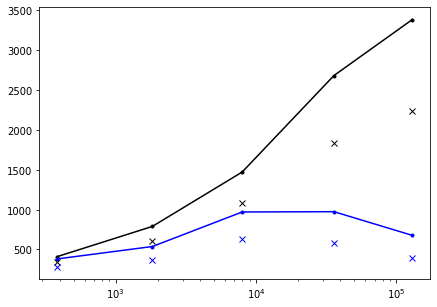

In [4]:
fig, axes = plt.subplots(1,1, figsize = (7,5))
axes.plot(FDsurvey.frequency, d_true[0:FDsurvey.n_frequency], 'k.-')
axes.plot(FDsurvey.frequency, d_true[FDsurvey.n_frequency:], 'b.-')
axes.plot(FDsurvey.frequency, d_dh[0:FDsurvey.n_frequency], 'kx')
axes.plot(FDsurvey.frequency, d_dh[FDsurvey.n_frequency:], 'bx')
axes.set_xscale('log')

In [5]:
from SimPEG import regularization, data

In [6]:
std = 0.07
floor = 0.
np.random.seed(1)
uncert = std*abs(d_true)+floor
noise = std*np.abs(d_true)*np.random.randn(len(d_true))
d_obs = d_true + noise
dataObj = data.Data(FDsurvey, dobs=d_obs, noise_floor=uncert)

dmisfit = data_misfit.L2DataMisfit(dataObj, sim)
dmisfit.W = utils.sdiag(1/uncert)
m0 = np.r_[np.log(np.ones_like(sig)*sig_half), 45.]
reg_sigma = regularization.Sparse(
    mesh1D, mapping=wires.sigma, cell_weights=mesh1D.vol,
    alpha_s = 0.01
)
p=0.
qx, qz = 1., 1.
reg_sigma.norms = np.c_[p, qx, qz, 0.]
IRLS = directives.Update_IRLS(
    max_irls_iterations=20, minGNiter=1, fix_Jmatrix=True, coolingRate=2, 
    beta_tol=1e-2,
    chifact_start = 1.
)
mesh_h = TensorMesh([1])
reg_h = regularization.Sparse(
    mesh_h, mapping=wires.h, 
    alpha_s = 1.
)
reg = reg_sigma + reg_h
opt = optimization.ProjectedGNCG(maxIter = 40)
opt.maxIterLS = 5
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)
beta = directives.BetaSchedule(coolingFactor=2, coolingRate=2)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = directives.TargetMisfit()
update_sense = directives.UpdateSensitivityWeights()
inv = inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])
# inv = Inversion.BaseInversion(invProb, directiveList=[IRLS, betaest])
# inv = Inversion.BaseInversion(invProb, directiveList=[IRLS])

# prob.counter = opt.counter = utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.56e+00  4.42e+02  0.00e+00  4.42e+02    3.90e+01      0              
   1  3.56e+00  2.92e+02  3.98e+00  3.06e+02    2.15e+01      1              
   2  1.78e+00  2.44e+02  1.42e+01  2.69e+02    3.15e+01      0   Skip BFGS  
   3  1.78e+00  1.02e+02  4.81e+01  1.87e+02    2.17e+01      0              
   4  8.89e-01  6.26e+01  6.18e+01  1.18e+02    1.66e+01      0              
   5  8.89e-01  1.43e+01  8.60e+01  9.08e+01    8.66e+00      0              
   6

In [7]:
print (wires.h*m0)
print (wires.h*mopt)
print (FDsurvey.h)

[45.]
[31.38778403]
30.0


Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['floor', 'inv', 'beta', 'std', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


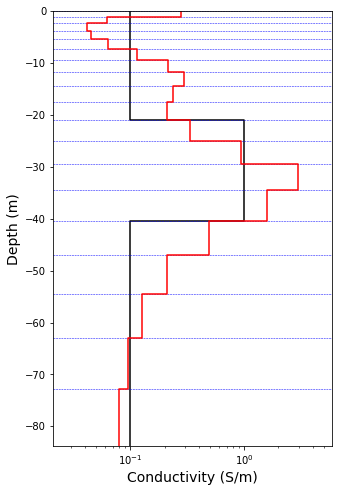

In [8]:
%pylab inline
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D, showlayers=False)
Utils1D.plotLayer(sigmaMap*mopt, mesh1D, showlayers=True, **{'color':'r'})
# Utils1D.plotLayer(sigmaMap*invProb.l2model, LocSigZ, showlayers=True,**{'color':'g'})

<bound method Axes.set_xlabel of <matplotlib.axes._subplots.AxesSubplot object at 0x00000178C95E0CC8>>

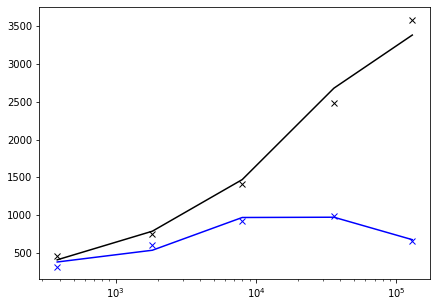

In [9]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(FDsurvey.frequency, d_true[0:FDsurvey.n_frequency], 'k-')
axes.plot(FDsurvey.frequency, d_true[FDsurvey.n_frequency:], 'b-')
axes.plot(FDsurvey.frequency, d_obs[0:FDsurvey.n_frequency], 'kx')
axes.plot(FDsurvey.frequency, d_obs[FDsurvey.n_frequency:], 'bx')
axes.set_xscale('log')
axes.set_xlabel